In [23]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from validation import TimeSeriesWalkingForwardCV, TimeSeriesWindowCV
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

plt.rcParams["figure.figsize"] = (40, 20)

In [7]:
%store -r features_scaled
%store -r data_cp
%store -r Y

In [8]:
features = features_scaled[24*60:-24*30]
targets = Y[24*60:-24*30]
dates = data_cp.date_time.dt.date[24*60:-24*30]

In [9]:
def MAE(x, y):
    return (np.abs(x - y)).mean(axis=0)

def RelativeAE(x, y):
    return (np.abs(x - y)).sum(axis=0) / np.abs(y).sum(axis=0)

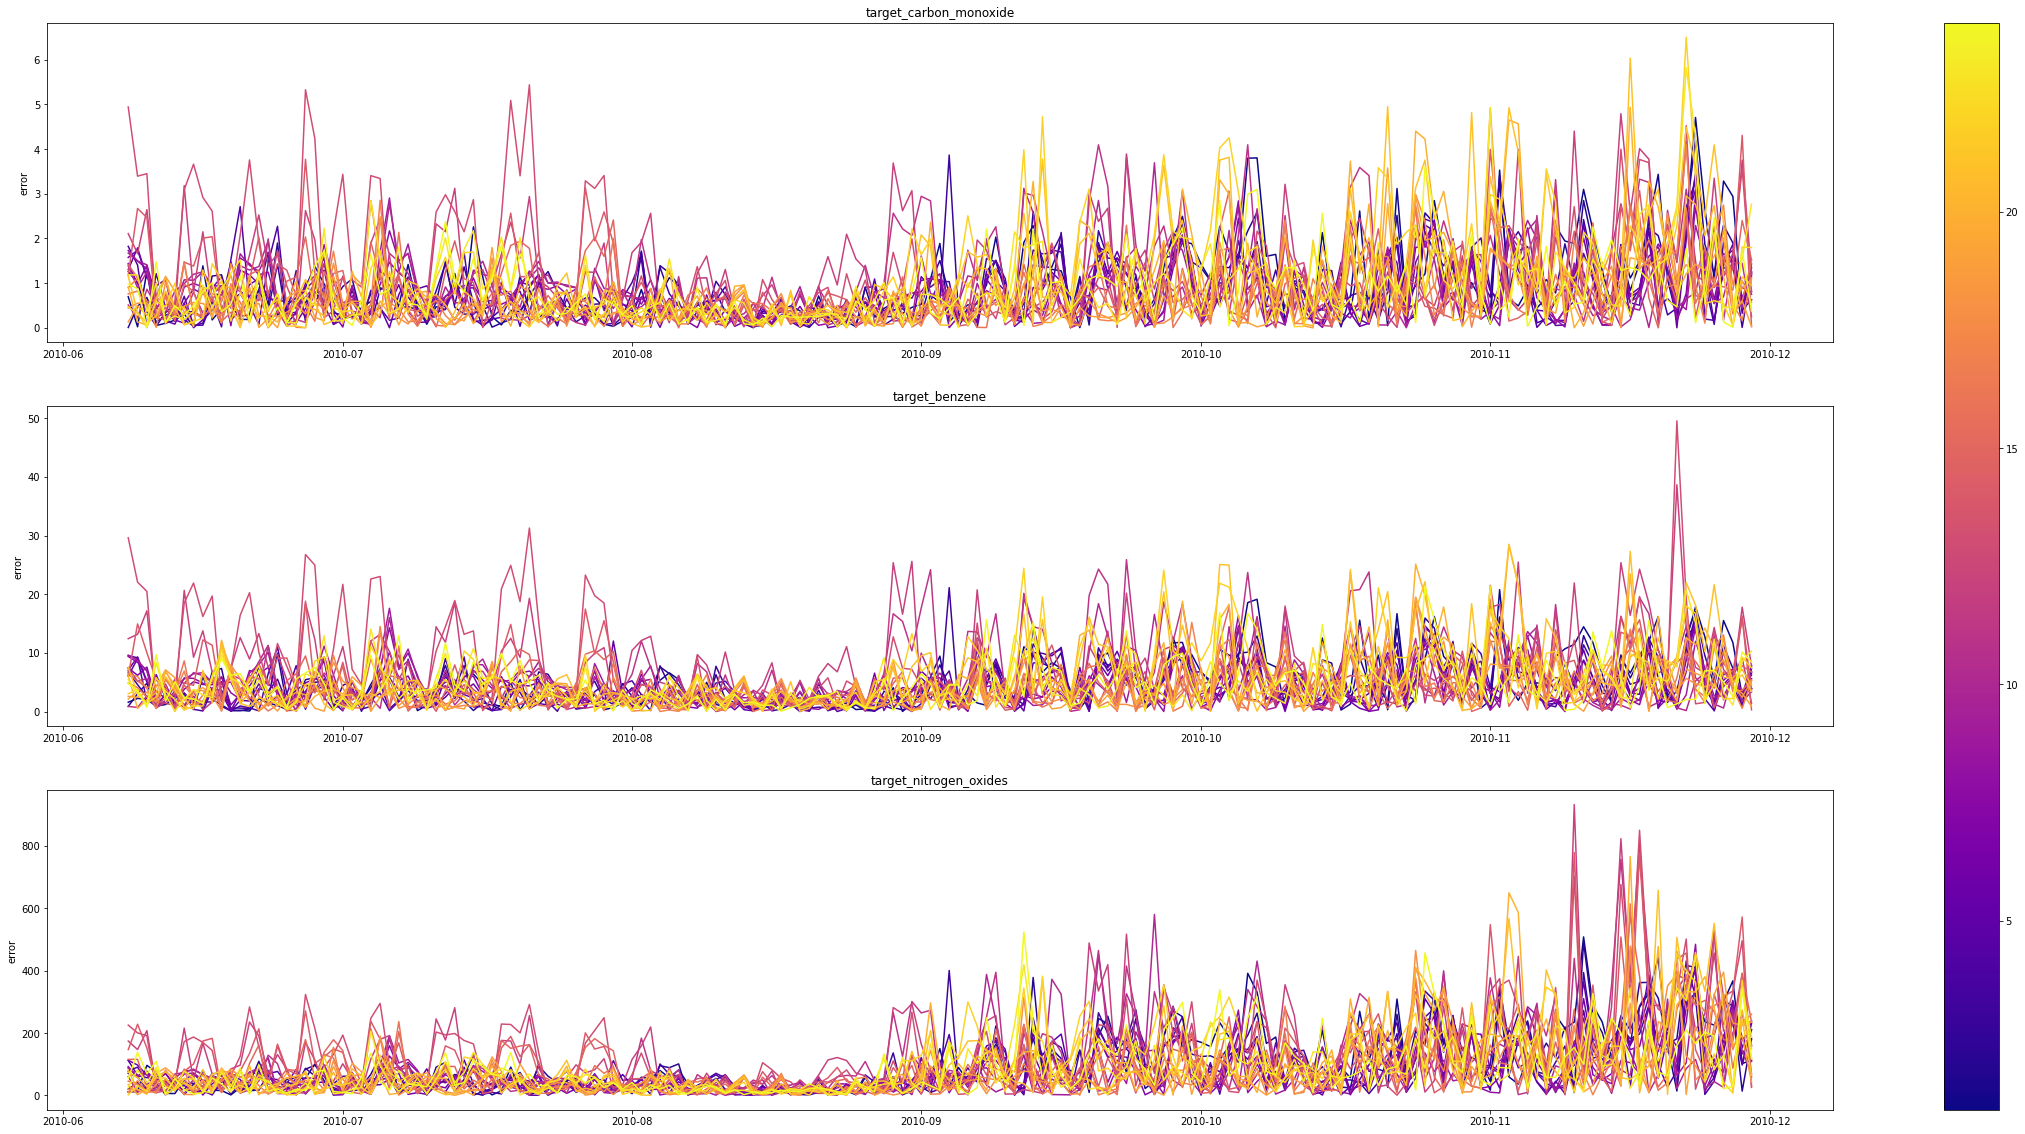

In [13]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')

optimizer_ridge = TimeSeriesWindowCV(Ridge, 24*30, 24, 24, fig, axs, dates, param_grid={'alpha': [2], 'tol':[1e-4]})
optimizer_ridge.fit(features, np.array(targets), MAE)

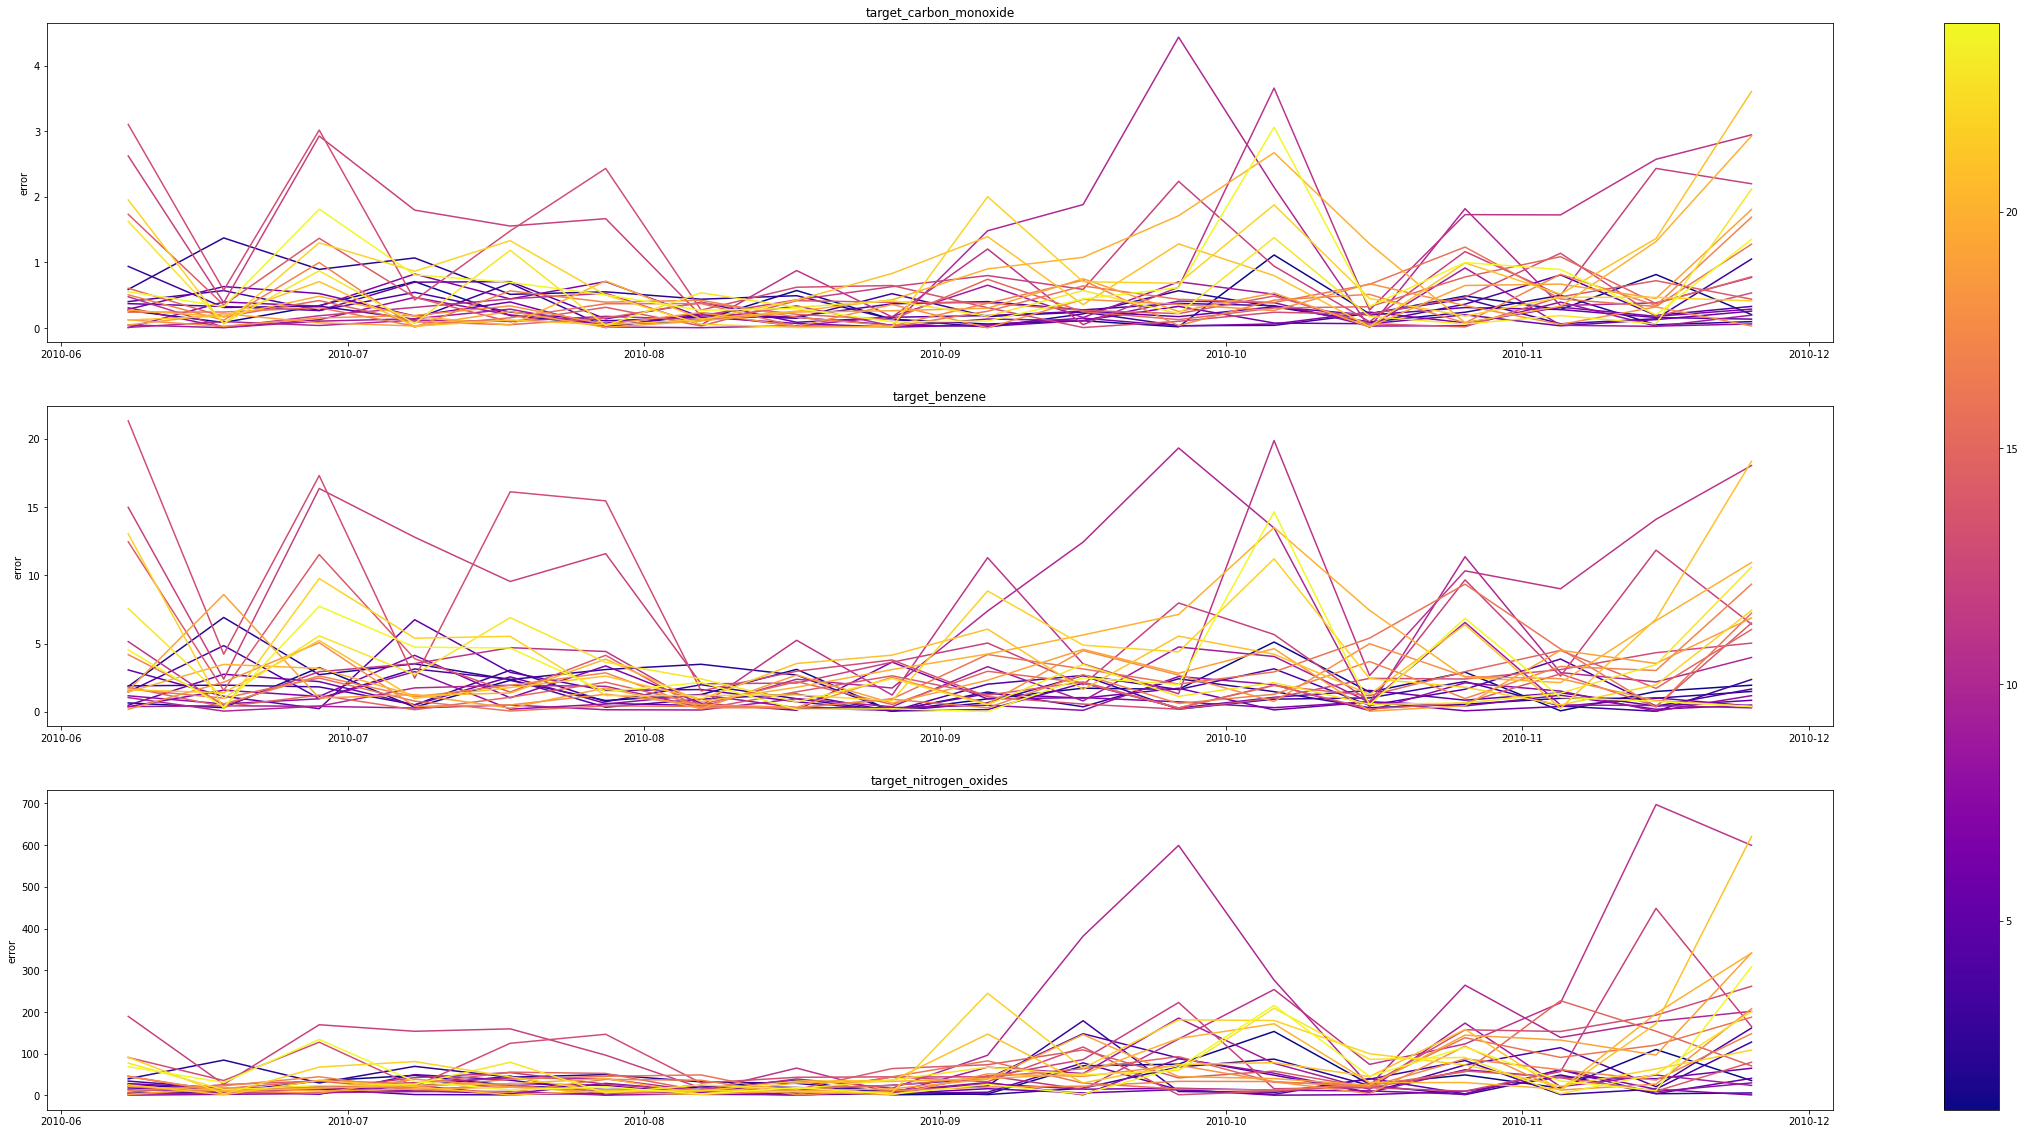

In [5]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWindowCV(XGBRegressor, 24*30, 24, 240, fig, axs, dates, param_grid={'max_depth': [10], 'n_estimators': [20], 'learning_rate': [0.1], 'min_child_weight': [3]})
optimizer_forest.fit(features, targets, MAE)

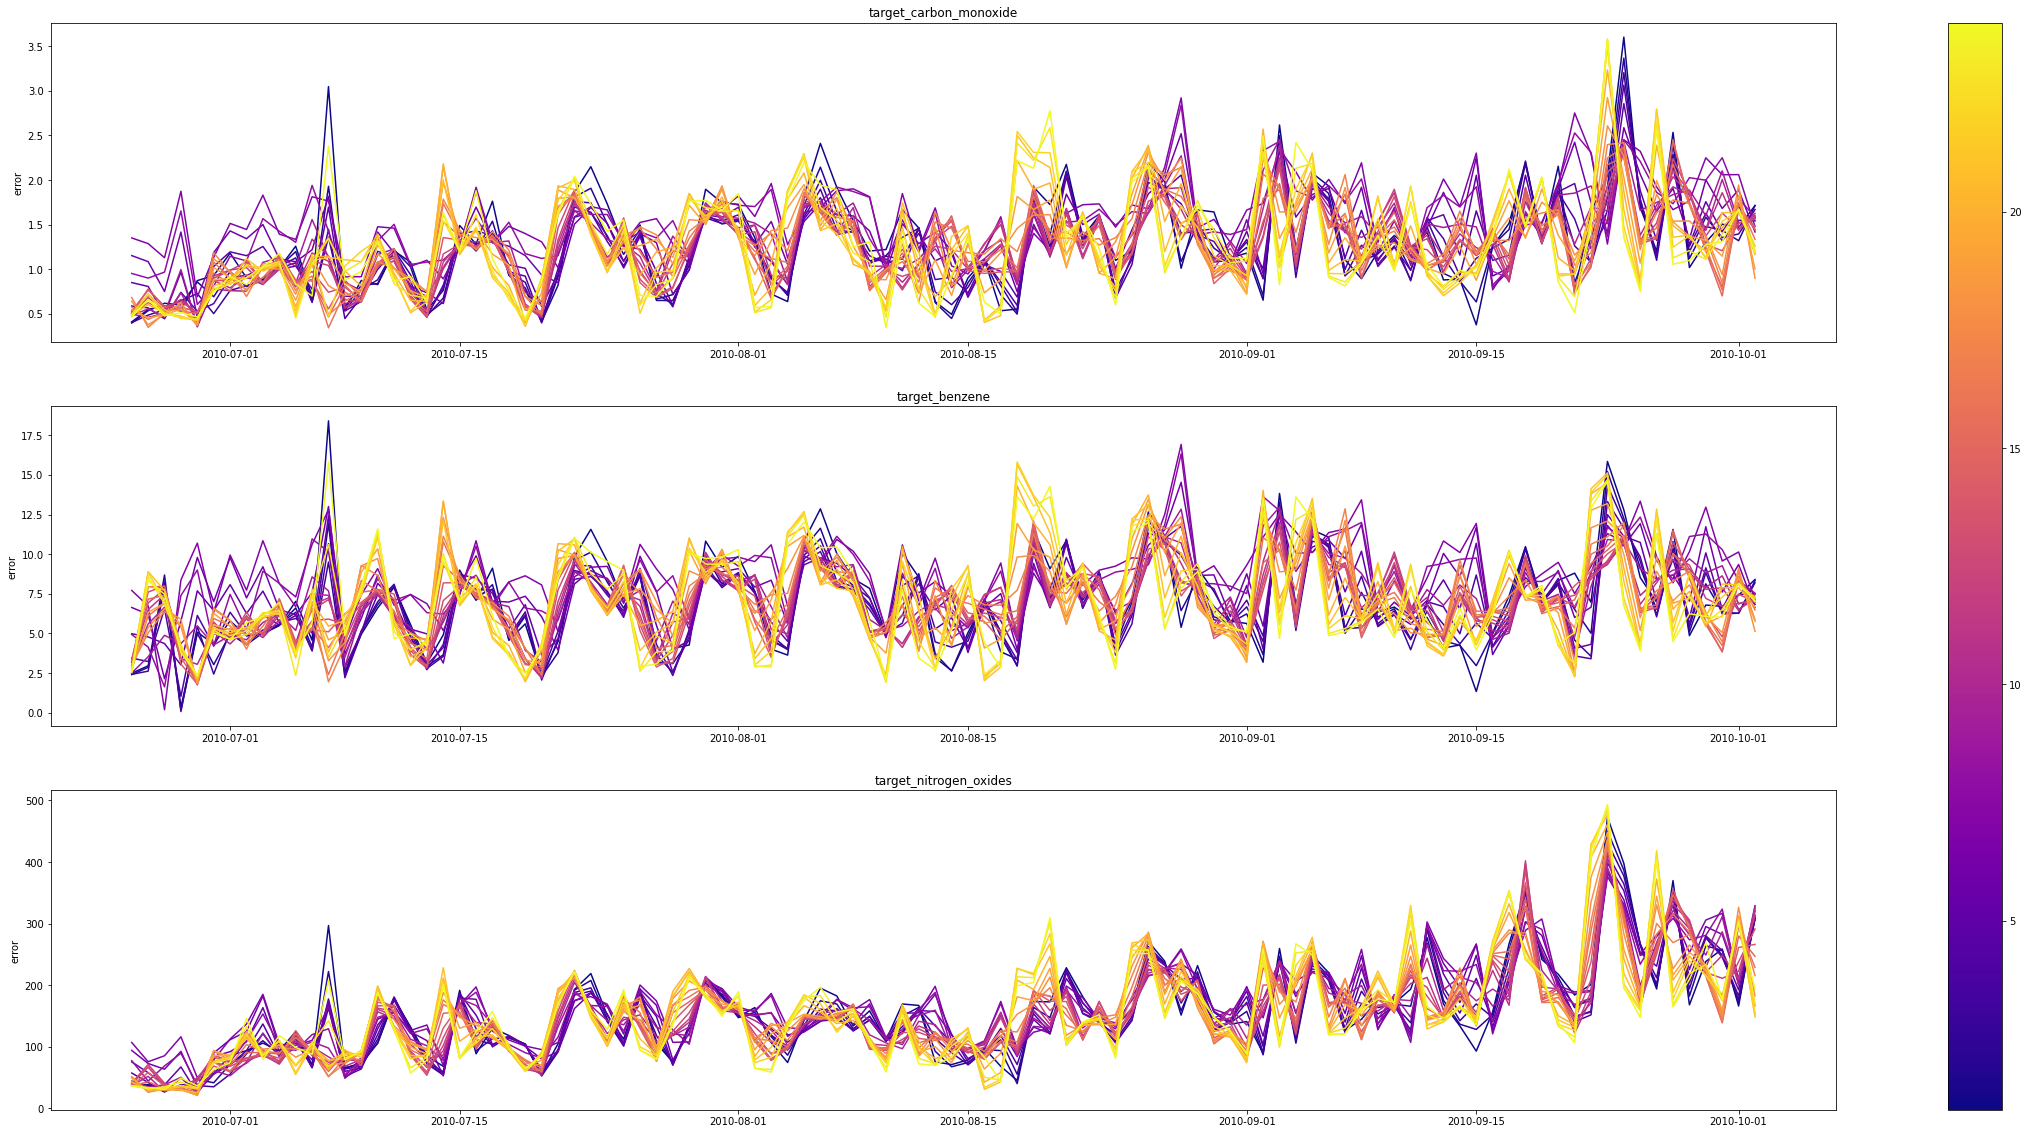

In [5]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')

optimizer_ridge = TimeSeriesWalkingForwardCV(Ridge, test_size=24, n_splits=100, fig=fig, axs=axs, dates=dates, param_grid={'alpha': [0.05], 'tol':[1e-4]})
optimizer_ridge.fit(features, np.array(targets), MAE)

In [6]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

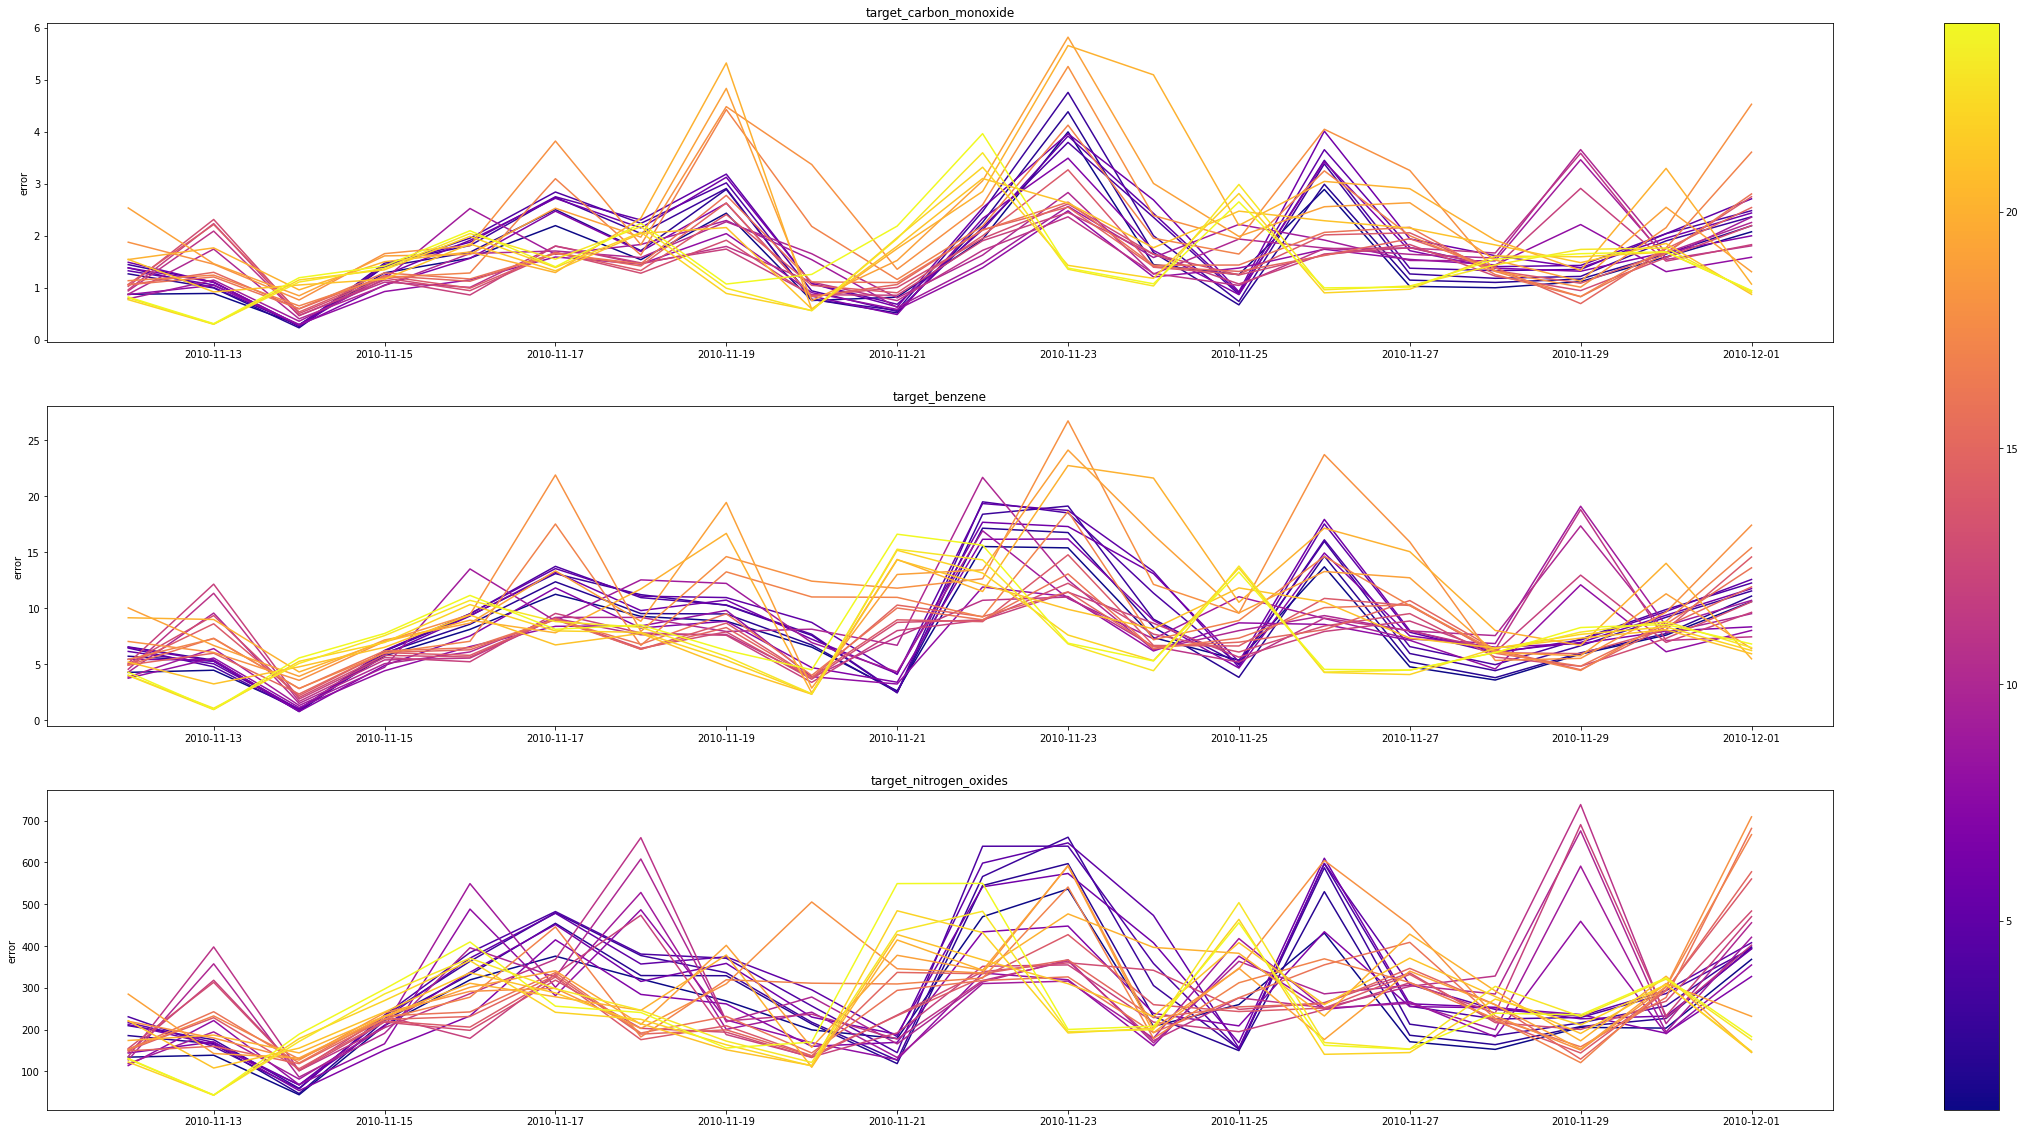

In [11]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWalkingForwardCV(XGBRegressor, test_size=24, n_splits=20, fig=fig, axs=axs, dates=dates, param_grid={'max_depth': [30], 'n_estimators': [30], 'learning_rate': [0.1], 'min_child_weight': [3], 'reg_alpha': [0.1]})
optimizer_forest.fit(features, targets, MAE)

In [10]:
def train_models(estimator, X_train, Y_train, horizons_n: int, params: dict):
    models = []
    for i in range(horizons_n):
        X_train = X_train[:-1]
        Y_train = Y_train.shift(-1).dropna()
        
        model = MultiOutputRegressor(estimator(**params))
        model.fit(X_train, Y_train)
        
        models.append(model)
        
        print(f'{(i + 1) / (horizons_n) * 100:.2f}%', end='\r')
    
    return models

def predict(models, X_point):
    result = np.zeros(shape=(len(models), 3))
    
    for i, m in enumerate(models):
        result[i] = m.predict(np.array([X_point]))
    
    return result

In [31]:
h = 24*30

In [32]:
models = train_models(XGBRegressor, features_scaled[:-h], Y[:-h], h, params={'max_depth': 30, 'n_estimators': 30, 'learning_rate': 0.1, 'min_child_weight': 3, 'reg_alpha': 0.1})

In [33]:
result = predict(models, features_scaled[-h])

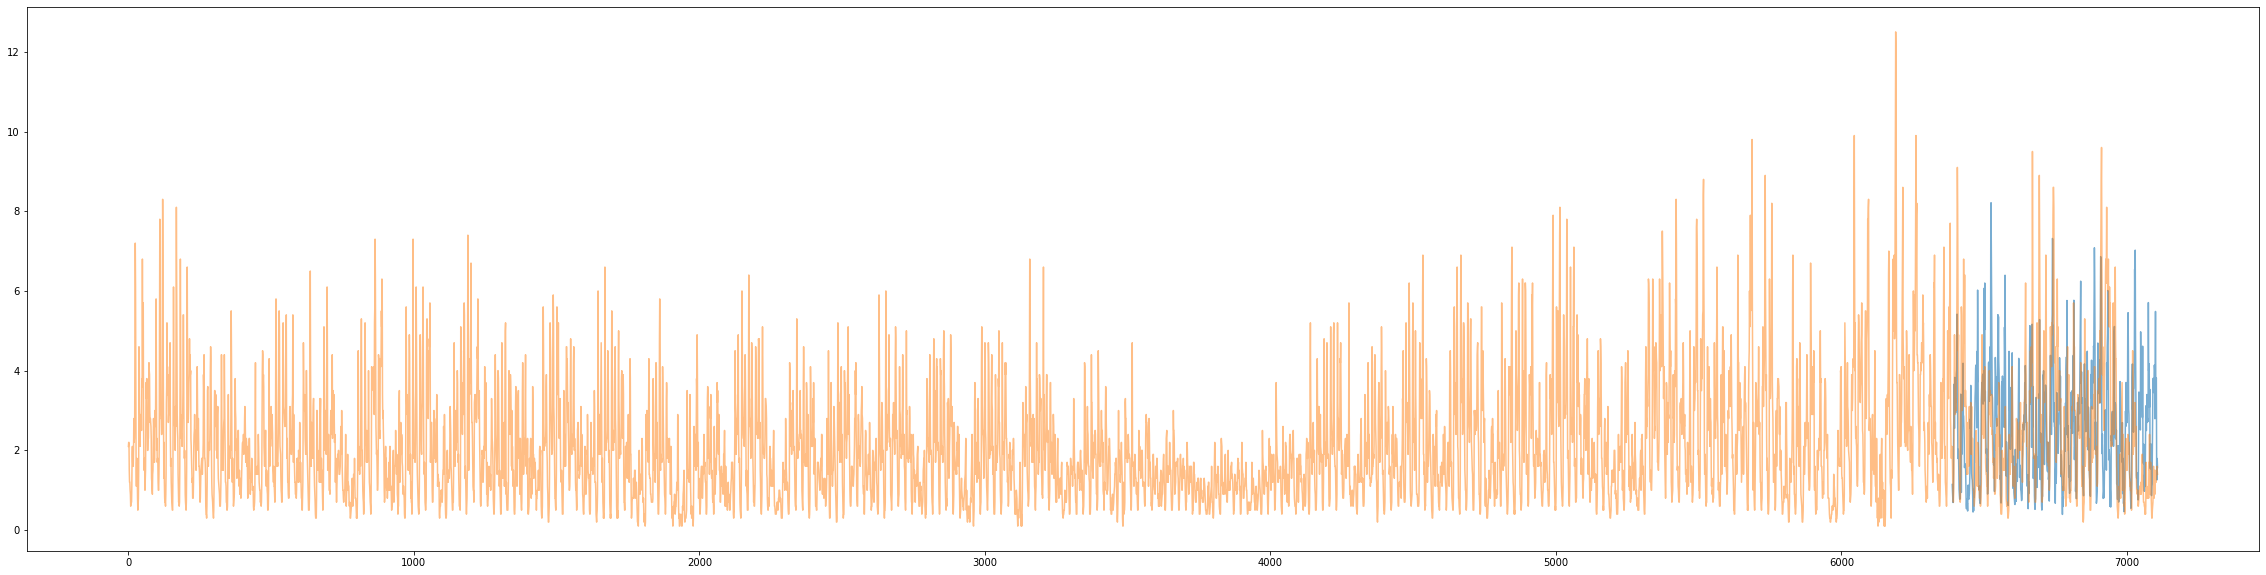

In [40]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 0], alpha=0.6)
plt.plot(list(range(len(Y))), Y['target_carbon_monoxide'], alpha=0.5)

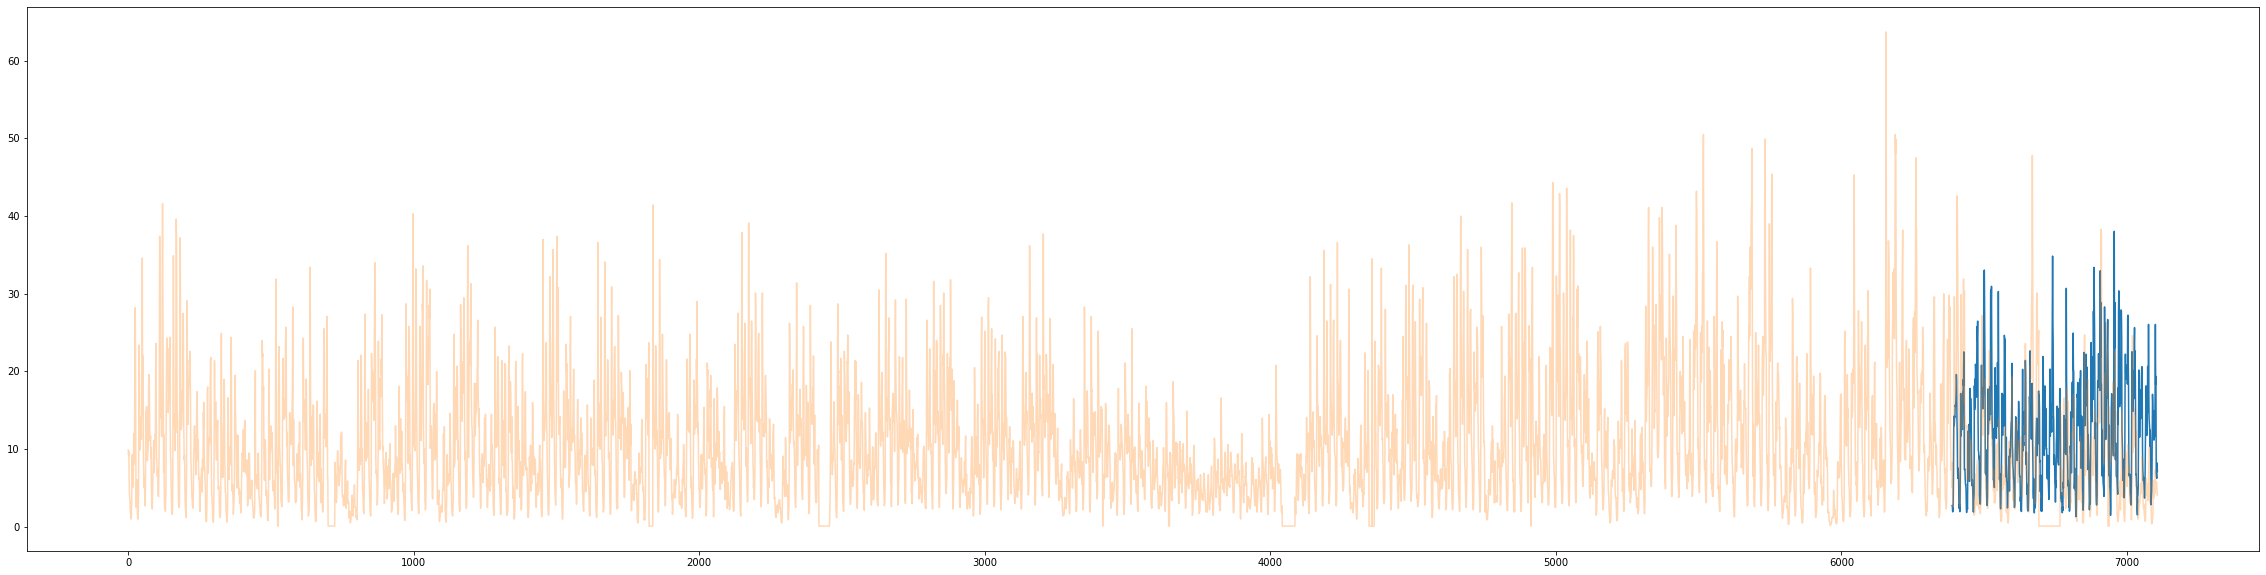

In [35]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 1])
plt.plot(list(range(len(Y))), Y['target_benzene'], alpha=0.3)

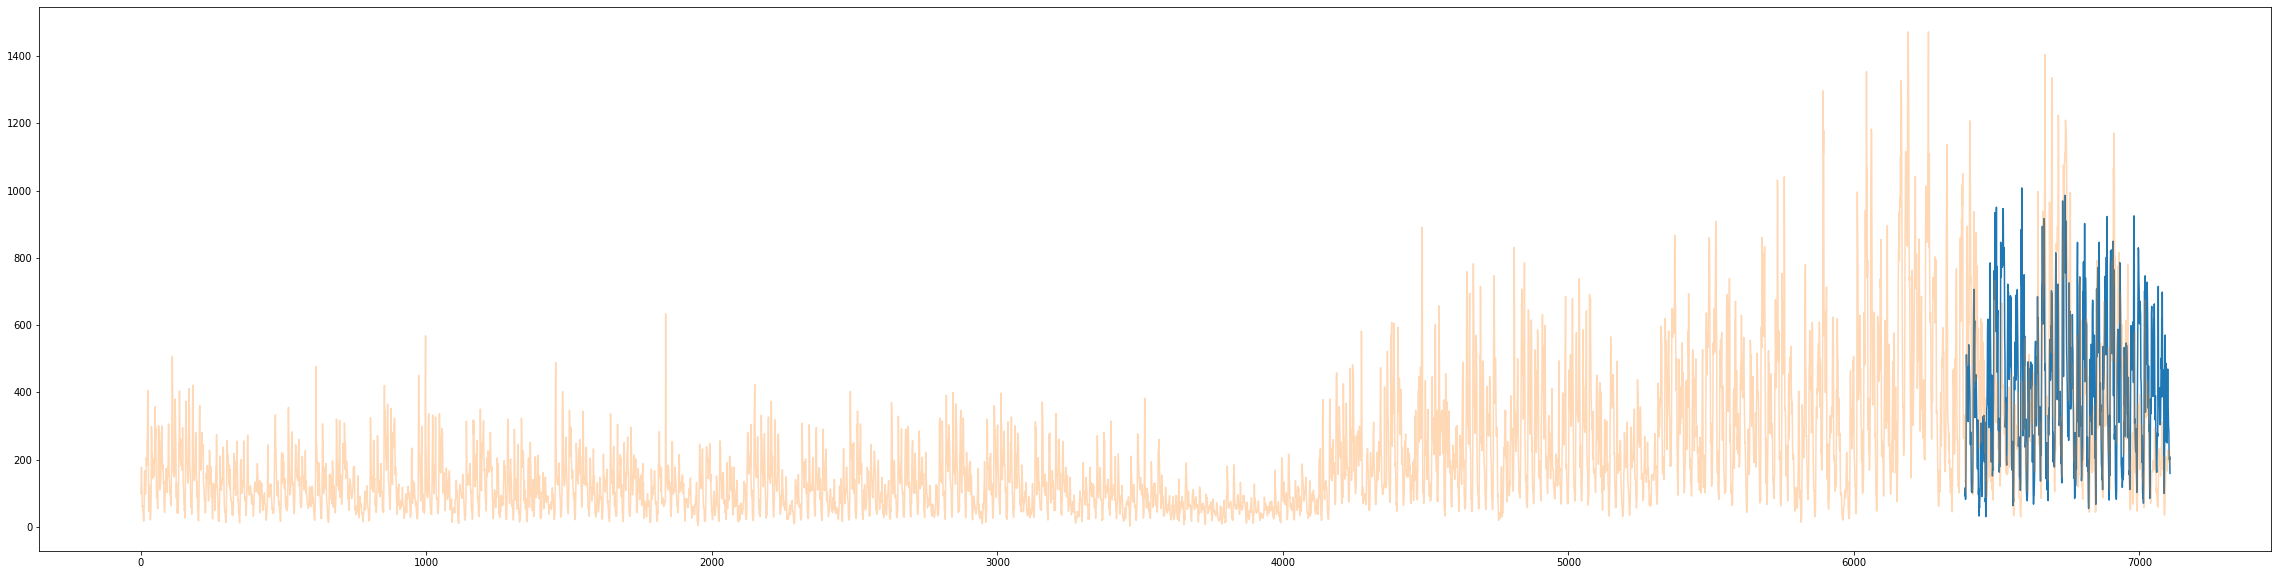

In [36]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 2])
plt.plot(list(range(len(Y))), Y['target_nitrogen_oxides'], alpha=0.3)

In [21]:
def train_and_predict(estimator, X_train, Y_train, horizons_n, params):
    result = np.zeros(shape=(horizons_n, 3))
    X_train = X_train[:-1]
    for i in range(horizons_n):
        Y_train = Y_train.shift(-1).dropna()
        
        model = MultiOutputRegressor(estimator(**params))
        model.fit(X_train, Y_train)
        
        result[i] = model.predict(np.array([X_train[-1]]))
        Y_train = Y_train.append(pd.DataFrame(np.array([result[-1]]), columns=Y_train.columns), ignore_index=True)
        
        print(f'{(i + 1) / (horizons_n) * 100:.2f}%', end='\r')
    
    return result

In [24]:
result = train_and_predict(XGBRegressor, features_scaled[:-h], Y[:-h], h, params={'max_depth': 5, 'n_estimators': 5, 'learning_rate': 0.1, 'min_child_weight': 3, 'reg_alpha': 0.1})

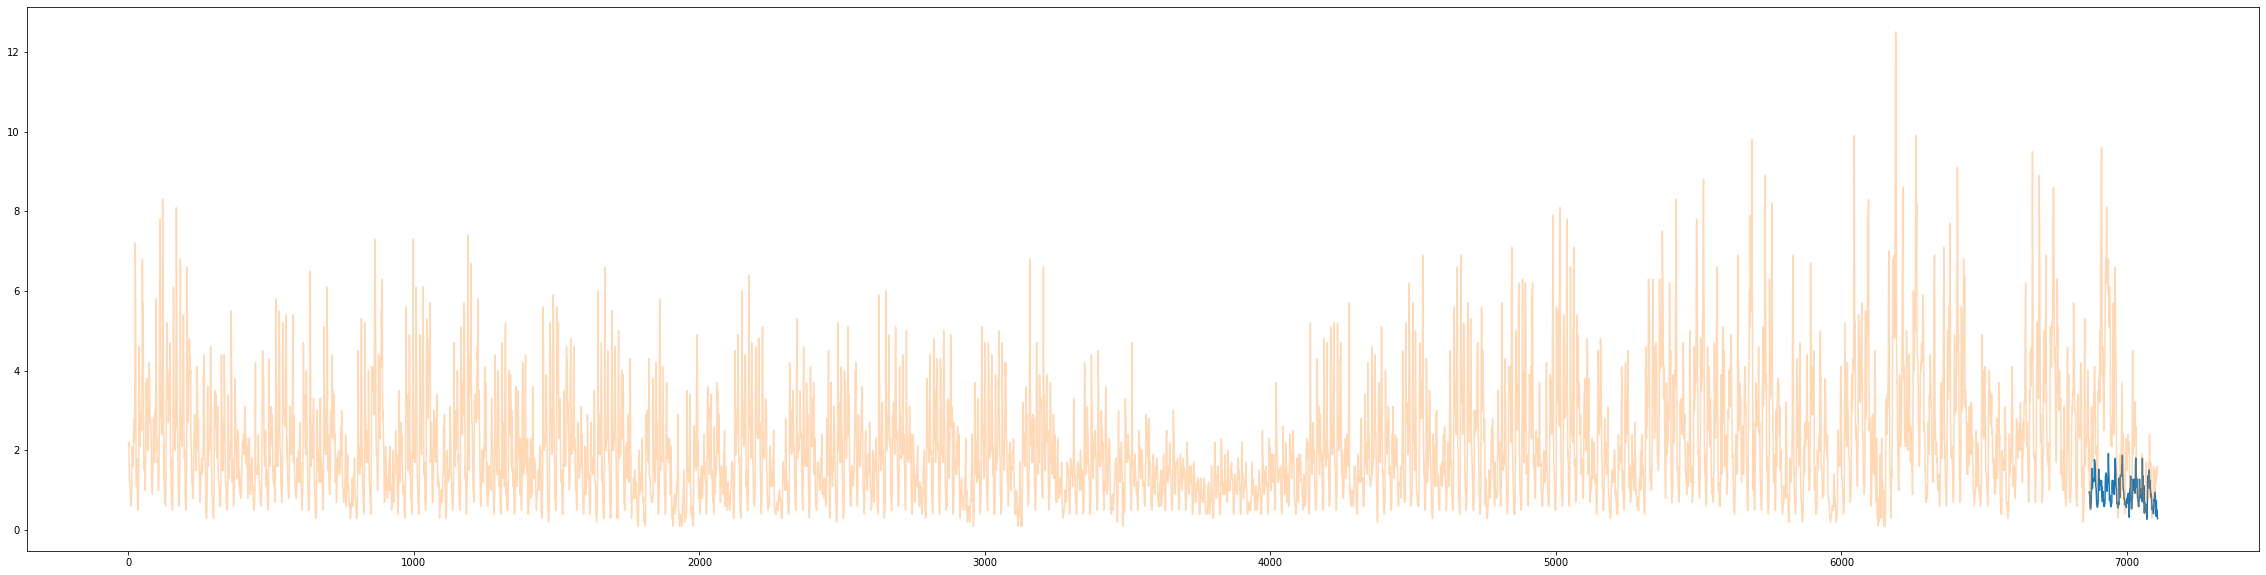

In [25]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 0])
plt.plot(list(range(len(Y))), Y['target_carbon_monoxide'], alpha=0.3)

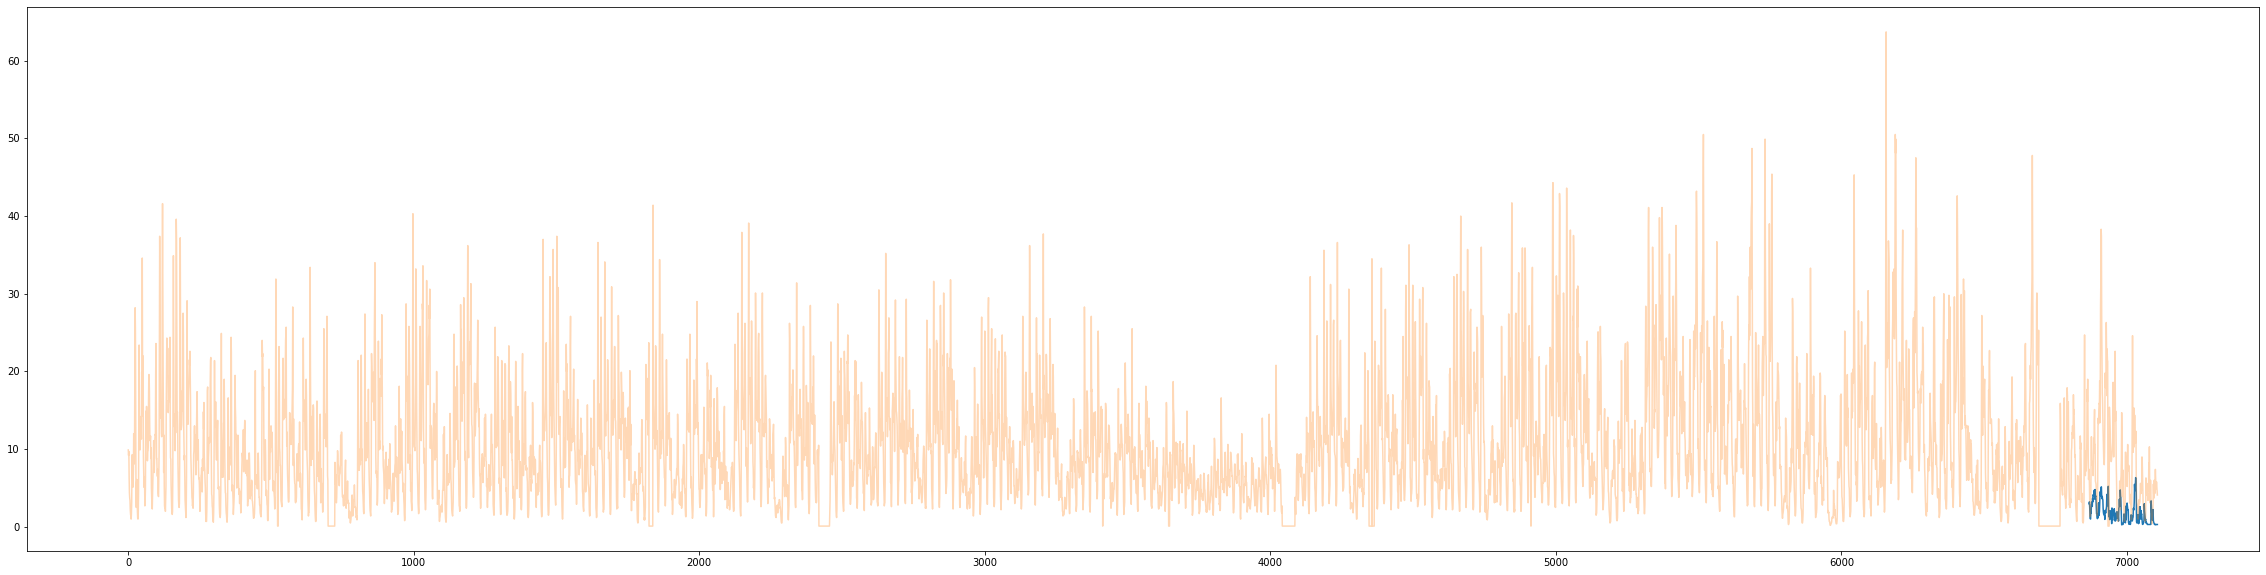

In [26]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 1])
plt.plot(list(range(len(Y))), Y['target_benzene'], alpha=0.3)

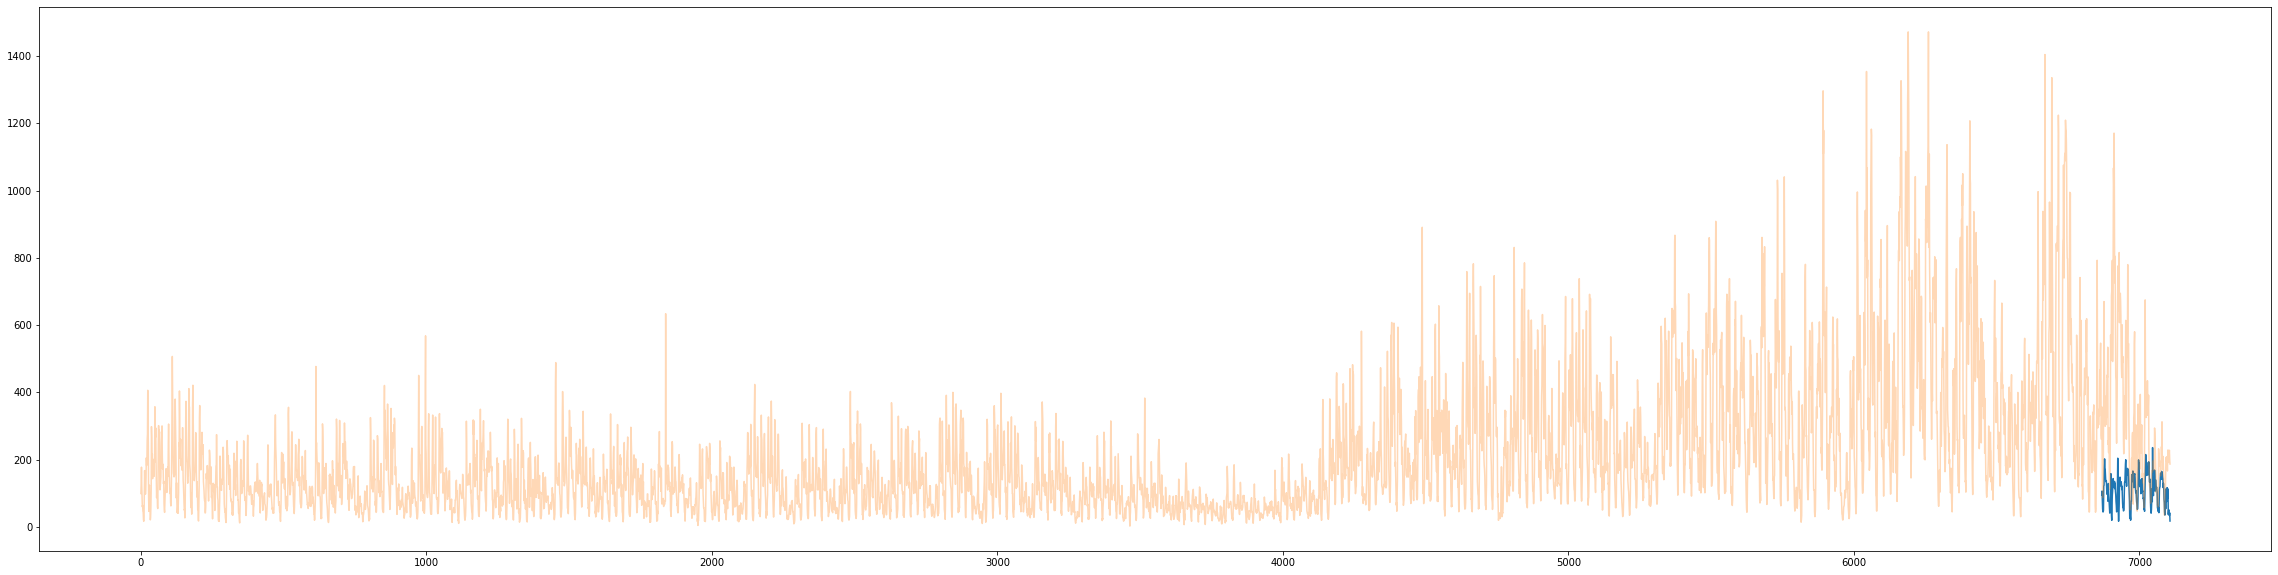

In [27]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 2])
plt.plot(list(range(len(Y))), Y['target_nitrogen_oxides'], alpha=0.3)